In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine)

In [6]:
# View all of the classes that automap found
from sqlalchemy import inspect

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Look at columns in both tables
for table in ['measurement', 'station']:
    print(table.upper())
    for column in inspector.get_columns(table):
        print(column['name'], column['type'])
    print("\n")

MEASUREMENT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


STATION
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT




In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
res = session.query(func.max(Measurement.date)).first()
most_recent_date = res[0]
print(most_recent_date)
print(type(most_recent_date))

2017-08-23
<class 'str'>


In [11]:
from datetime import datetime as dt, timedelta

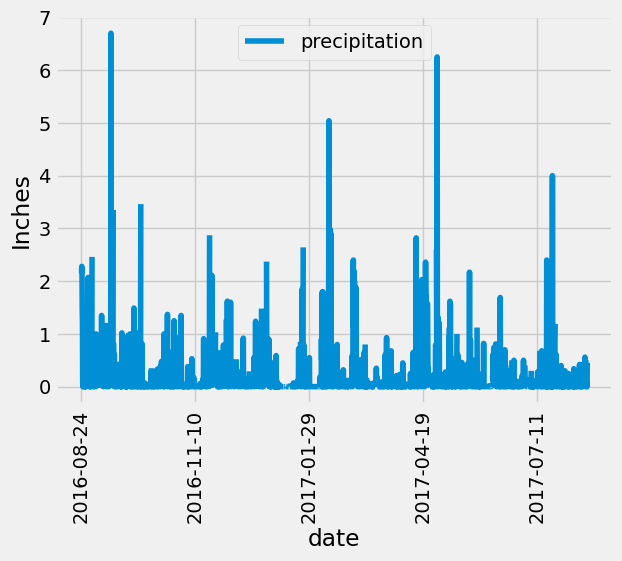

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# help from: end_date = dt.strptime(most_recent_date, "%Y-%m-%d") - timedelta(days=365)
# help from: https://www.w3schools.com/python/gloss_python_date_format_codes.asp
end_date = dt.strptime(most_recent_date, "%Y-%m-%d") - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= end_date, Measurement.date <= most_recent_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])

# Sort the dataframe by date
precipitation_data_df.sort_values(by="date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data_df.plot("date", "precipitation")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_data_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).group_by(Station.station).count()
station_count

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# help from: https://stackoverflow.com/questions/4186062/sqlalchemy-order-by-descending
ordered_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

for row in ordered_stations:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = 'USC00519281'
most_active_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_id).first()
print(most_active_data)

(54.0, 85.0, 71.66378066378067)


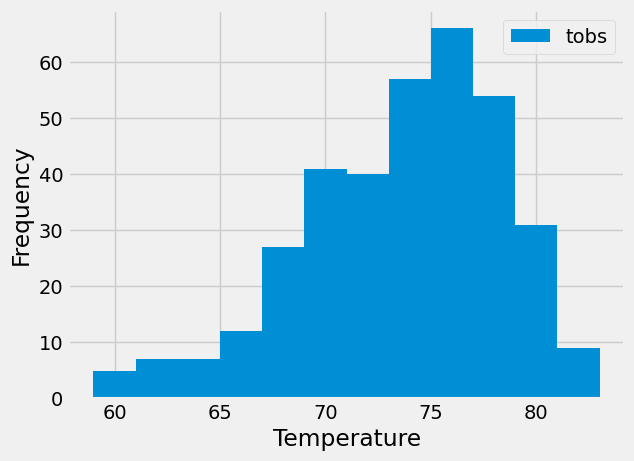

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
end_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_id).first()[0]

start_date = dt.strptime(end_date, "%Y-%m-%d") - timedelta(days=365)

temp_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date <= end_date, Measurement.date >= start_date, Measurement.station == most_active_id)

temp_data_df = pd.DataFrame(temp_data, columns=["date", "Temperature"])

plt.hist(temp_data_df["Temperature"], bins=12)

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(labels=["tobs"])

plt.show()

# Close Session

In [18]:
# Close Session
session.close()